In [1]:
#for matrix manipulation
import numpy as np
#for visualization the dataset
import matplotlib.pyplot as plt
#file manipulation
import pandas as pd
import math
import time
from datetime import datetime
%matplotlib inline

#our machine learning libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.core import Activation, Dense,Dropout

from sklearn import cross_validation
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
appl_stock = pd.read_csv('nasdaq/AAPL.csv', parse_dates=['Time'])
appl_sent = pd.read_json('sentiment/appl_parse.json')
                  
dataframe = appl_stock
print(dataframe.head())
print(len(dataframe))

                 Time   First    Last
0 2008-01-02 09:00:00  198.79  200.16
1 2008-01-02 10:00:00  200.16  198.05
2 2008-01-02 11:00:00  198.05  195.12
3 2008-01-02 12:00:00  195.12  194.47
4 2008-01-02 13:00:00  194.46  194.98
17418


In [3]:
print(type(appl_stock['Time'][0]))
print(type(appl_sent['date'][0]))
print(appl_sent.head())

<class 'pandas._libs.tslib.Timestamp'>
<class 'pandas._libs.tslib.Timestamp'>
   bearish  bearish_percent  bullish  bullish_percent       date  none  total
0        0              0.0        4            100.0 2011-01-03   105    109
1        0              0.0        2            100.0 2011-01-04    59     61
2        0              0.0        1            100.0 2011-01-05    58     59
3        0              0.0        1            100.0 2011-01-06    91     92
4        0              0.0        2            100.0 2011-01-07    92     94


In [4]:
appl_stock['Time_nohour'] = appl_stock['Time']
appl_stock['Time_nohour'] = appl_stock['Time_nohour'].apply((lambda ts: pd.Timestamp(datetime( ts.year, ts.month, ts.day))))

print(appl_stock['Time_nohour'])

0       2008-01-02
1       2008-01-02
2       2008-01-02
3       2008-01-02
4       2008-01-02
5       2008-01-02
6       2008-01-02
7       2008-01-02
8       2008-01-03
9       2008-01-03
10      2008-01-03
11      2008-01-03
12      2008-01-03
13      2008-01-03
14      2008-01-03
15      2008-01-03
16      2008-01-04
17      2008-01-04
18      2008-01-04
19      2008-01-04
20      2008-01-04
21      2008-01-04
22      2008-01-04
23      2008-01-04
24      2008-01-07
25      2008-01-07
26      2008-01-07
27      2008-01-07
28      2008-01-07
29      2008-01-07
           ...    
17388   2016-09-07
17389   2016-09-07
17390   2016-09-07
17391   2016-09-07
17392   2016-09-07
17393   2016-09-07
17394   2016-09-08
17395   2016-09-08
17396   2016-09-08
17397   2016-09-08
17398   2016-09-08
17399   2016-09-08
17400   2016-09-08
17401   2016-09-08
17402   2016-09-09
17403   2016-09-09
17404   2016-09-09
17405   2016-09-09
17406   2016-09-09
17407   2016-09-09
17408   2016-09-09
17409   2016

In [5]:
dataframe = appl_stock
dataframe_merge = pd.merge(appl_stock, appl_sent, left_on = 'Time_nohour', right_on='date')
print(dataframe_merge.head())

                 Time   First    Last Time_nohour  bearish  bearish_percent  \
0 2011-01-03 09:00:00  324.82  327.47  2011-01-03        0              0.0   
1 2011-01-03 10:00:00  327.50  329.91  2011-01-03        0              0.0   
2 2011-01-03 11:00:00  329.94  329.71  2011-01-03        0              0.0   
3 2011-01-03 12:00:00  329.72  329.56  2011-01-03        0              0.0   
4 2011-01-03 13:00:00  329.62  329.95  2011-01-03        0              0.0   

   bullish  bullish_percent       date  none  total  
0        4            100.0 2011-01-03   105    109  
1        4            100.0 2011-01-03   105    109  
2        4            100.0 2011-01-03   105    109  
3        4            100.0 2011-01-03   105    109  
4        4            100.0 2011-01-03   105    109  


In [6]:
dataset = (0.5 * (dataframe['First'] + dataframe['Last'])).values
sent_dataset = dataframe_merge['bullish_percent'].values
print(dataset)
print(dataset.reshape(1,-1))

[ 199.475  199.105  196.585 ...,  105.205  105.455  105.445]
[[ 199.475  199.105  196.585 ...,  105.205  105.455  105.445]]


In [7]:

scaler = MinMaxScaler(feature_range=(0,1))
sent_scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset.reshape(-1,1))
sent_dataset = sent_scaler.fit_transform(sent_dataset.reshape(-1,1))
print(dataset.shape)
print(sent_dataset.shape)

(17418, 1)
(11063, 1)


In [8]:
def rnnDataPrep(data, n_prev):
    X_data, y_data = [], []
    for i in range(n_prev, len(data)):
        X_data.append( data[i - (n_prev) : i].tolist())
    X_data = np.array(X_data)
    y_data = data[n_prev:]
    return np.reshape(X_data, (X_data.shape[0], X_data.shape[1], 1)), np.reshape(y_data, (len(y_data), ))
  

def rnnDataPrepSent(data, n_prev):
    X_data, y_data = [],[]
    
    for i in range(n_prev, len(data)):
        X_data.append(np.append( data[i - (n_prev) : i], sent_dataset[i -1]).tolist())
        
    X_data = np.array(X_data)
    y_data = data[n_prev:]
    
    return np.reshape(X_data, (X_data.shape[0], X_data.shape[1], 1), np.reshape(y_data, len(y_data),))


temp_x, temp_y = rnnDataPrep(dataset, 10)
print(temp_x.shape, temp_y.shape)

(17408, 10, 1) (17408,)


In [9]:
#spliting of data into training and testing dataset

ttR = 0.6 #train test ratio

lb = 50 # look_back
X, y = rnnDataPrep(dataset, lb)
n = int(ttR * len(X))

X_train, y_train = X[:n], y[:n]
X_test, y_test = X[n:], y[n:]

print(len(dataset))
print( X_train.shape, X_test.shape)
print( y_train.shape, y_test.shape)

17418
(10420, 50, 1) (6948, 50, 1)
(10420,) (6948,)


In [16]:
#create the LSTM model

def build_singlyr_model():
    
    model = Sequential()
    layers = [1, 50, 100, 1]
    
    model.add(LSTM( input_dim = layers[0], output_dim = layers[1],return_sequences=True ))
    model.add(Dropout(0.2))
    model.add(LSTM( layers[2], return_sequences = False))
    model.add(Dropout(0.2))
    model.add(Dense( layers[3]))
    model.add(Activation('linear'))
   
    
    start = time.time()
    model.compile(loss = 'mse', optimizer='rmsprop')
    print("Compilation time : ",time.time() - start)
    return model


def build_model():
    model = Sequential()
    model.add(LSTM( input_dim=1, output_dim = 4))
    model.add(Dense( output_dim=1))
    start = time.time()
    model.compile(loss='mse', optimizer='rmsprop')
    print("Compilation time : ", time.time() - start)
    return model

model_unilayer = build_singlyr_model()
model_unilayer.fit(X_train, y_train, nb_epoch=10, batch_size=1, verbose=2)

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:8: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(input_shape=(None, 1), return_sequences=True, units=50)`


Compilation time :  0.03125357627868652


C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\keras\models.py:844: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/10
608s - loss: 0.0019
Epoch 2/10
621s - loss: 9.5511e-04
Epoch 3/10
625s - loss: 8.6076e-04
Epoch 4/10
598s - loss: 8.2297e-04
Epoch 5/10
619s - loss: 8.0471e-04
Epoch 6/10
599s - loss: 7.9938e-04
Epoch 7/10
619s - loss: 8.7500e-04
Epoch 8/10
9228s - loss: 9.6807e-04
Epoch 9/10
726s - loss: 0.0011
Epoch 10/10
663s - loss: 0.0017


In [18]:
baseline_testScore = scaler.inverse_transform(np.array([[mean_squared_error(y_test[10:], y_test[:-10])**.5]]))

trainScore = scaler.inverse_transform(np.array([[model_unilayer.evaluate(X_train, y_train, verbose=0)**.5]]))
testScore = scaler.inverse_transform(np.array([[model_unilayer.evaluate(X_test, y_test, verbose=0)**.5]]))

print("baseline test score = %.2f RMSE"%baseline_testScore)
print("train score = %.2f RMSE"%trainScore)
print("test score = %.2f RMSE"%testScore)

baseline test score = 99.90 RMSE
train score = 94.23 RMSE
test score = 100.81 RMSE


In [19]:
sent_lb = 1
X_sent, y_sent = rnnDataPrep(sent_dataset, sent_lb)[0], 0.5*(dataframe_merge['First'] + dataframe_merge['Last'])[1:]
n = int(ttR * len(X_sent))
print(len(X_sent), len(y_sent))
X_sent_train, y_sent_train = X_sent[:n], y_sent[:n]
X_sent_test, y_sent_test = X_sent[n:], y_sent[n:]


11062 11062


In [20]:
model_sent = build_singlyr_model()
model_sent.fit(X_sent_train, y_sent_train,  nb_epoch=50, batch_size=1,verbose=2)

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:8: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(input_shape=(None, 1), return_sequences=True, units=50)`


Compilation time :  0.03125286102294922


C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\keras\models.py:844: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/50
29s - loss: 92686.3141
Epoch 2/50
28s - loss: 11351.2747
Epoch 3/50
29s - loss: 10242.2252
Epoch 4/50
27s - loss: 10225.2018
Epoch 5/50
27s - loss: 10262.7872
Epoch 6/50
30s - loss: 10195.1271
Epoch 7/50
30s - loss: 10220.6690
Epoch 8/50
31s - loss: 10275.6707
Epoch 9/50
30s - loss: 10116.4850
Epoch 10/50
29s - loss: 10252.3787
Epoch 11/50
31s - loss: 10257.0941
Epoch 12/50
34s - loss: 10210.0913
Epoch 13/50
31s - loss: 10252.0902
Epoch 14/50
28s - loss: 10237.1790
Epoch 15/50
30s - loss: 10242.7707
Epoch 16/50
27s - loss: 10250.0292
Epoch 17/50
28s - loss: 10176.1859
Epoch 18/50
28s - loss: 10221.2495
Epoch 19/50
29s - loss: 10146.9129
Epoch 20/50
29s - loss: 10202.5013
Epoch 21/50
29s - loss: 10266.5351
Epoch 22/50
28s - loss: 10295.2098
Epoch 23/50
28s - loss: 10304.3834
Epoch 24/50
28s - loss: 10303.9323
Epoch 25/50
28s - loss: 10360.6626
Epoch 26/50
30s - loss: 10243.3322
Epoch 27/50
33s - loss: 10286.4717
Epoch 28/50
29s - loss: 10300.8982
Epoch 29/50
31s - loss: 10304

In [21]:
baseline_testScore_sent = sent_scaler.inverse_transform(np.array([[mean_squared_error(y_sent_test[10:], y_sent_test[:-10])**.5]]))

trainScore_sent = sent_scaler.inverse_transform(np.array([[model_unilayer.evaluate(X_sent_train, y_sent_train, verbose=0)**.5]]))
testScore_sent = sent_scaler.inverse_transform(np.array([[model_unilayer.evaluate(X_sent_test, y_sent_test, verbose=0)**.5]]))

print("baseline test score = %.2f RMSE"%baseline_testScore_sent)
print("train score = %.2f RMSE"%trainScore_sent)
print("test score = %.2f RMSE"%testScore_sent)

baseline test score = 182.53 RMSE
train score = 49297.39 RMSE
test score = 11031.00 RMSE


In [22]:
#generate prediction for training
y_train_pred = model_unilayer.predict(X_train)
y_test_pred = model_unilayer.predict(X_test)

y_sent_train_pred = model_sent.predict(X_sent_train)
y_sent_test_pred = model_sent.predict(X_sent_test)

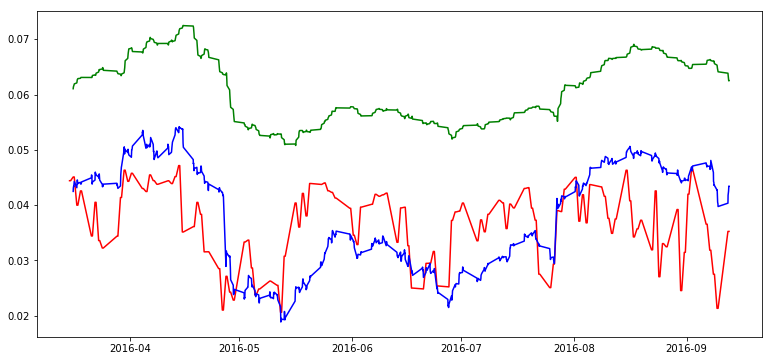

In [27]:
nn = 1000

plt.figure(figsize = (13, 6))


plt.plot(dataframe_merge['Time'][3:][-nn:], sent_dataset[3:][-nn:]/20, color='red')

plt.plot(dataframe['Time'][3:][-nn:], np.append(y_train, y_test)[-nn:], '-', ms=5, color='blue')

plt.plot(dataframe['Time'][3:][n:][-nn:], y_test_pred[-nn:],'-', ms=5, color='green')


plt.show()